Використовуючи датасет з файлу cardox.csv (обсяг продажів мережі супермаркетів) виконайте таку роботу:

проведіть попередній аналіз даних;

скорегуйте виявлені аномалії;

проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду тощо);

оберіть модель і здійсніть оцінку метрик;

зробіть кінцеву діагностику для отриманої моделі;

виконайте прогноз на 30 років;

збережіть результати прогнозування у файл.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Завантаження даних з CSV-файлу
df_cardox = pd.read_csv('cardox.csv')
# Виведення даних
df_cardox

import warnings
warnings.filterwarnings("ignore")

In [3]:
print(df_cardox.columns)

Index(['date', 'value'], dtype='object')


In [4]:
# Попередній аналіз даних
print(df_cardox.head())
print(df_cardox.info())

         date   value
0  1958-03-01  315.71
1  1958-04-01  317.45
2  1958-05-01  317.50
3  1958-06-01  317.10
4  1958-07-01  315.86
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    729 non-null    object 
 1   value   729 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.5+ KB
None


In [5]:
# Заповнення пропущених значень попередніми доступними значеннями
df_cardox['value'] = df_cardox['value'].fillna(method='bfill')

# Сортування даних за датою
df_cardox = df_cardox.sort_values('date')

# Виключення дублікатів
df_cardox = df_cardox.drop_duplicates()

In [6]:
# Перетворення на числові значення та типи дат
df_cardox['date'] = pd.to_datetime(df_cardox['date'])
df_cardox['value'] = pd.to_numeric(df_cardox['value'])

# Встановлення дати як індексу
df_cardox = df_cardox.set_index('date')

In [7]:
# Перевірка наявності пустих рядків
count_empty_rows = df_cardox.isnull().sum().sum()

# Виведення результатів
print("Кількість пустих рядків:", count_empty_rows)

Кількість пустих рядків: 0


In [8]:
df_cardox.columns

Index(['value'], dtype='object')

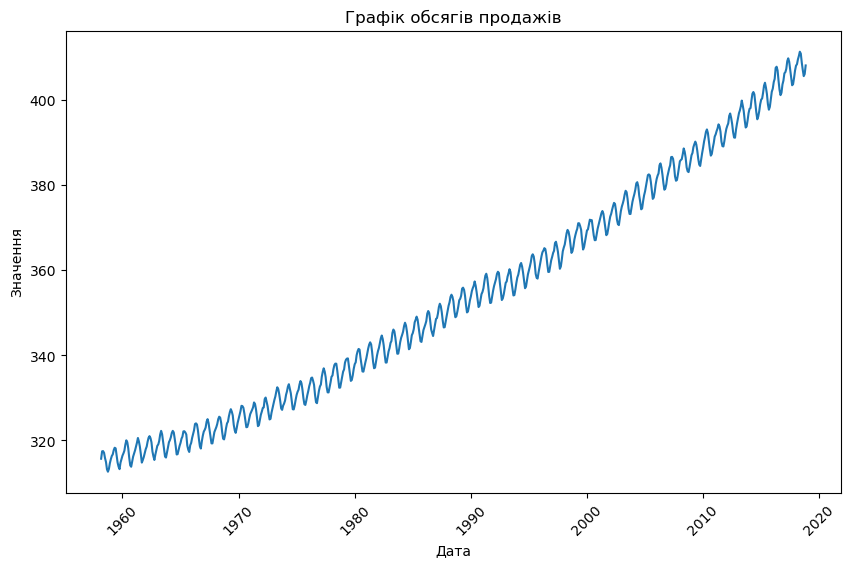

In [9]:
# Побудова графіків після внесення змін
plt.figure(figsize=(10, 6))
plt.plot(df_cardox.index, df_cardox['value'])
plt.xlabel('Дата')
plt.ylabel('Значення')
plt.title('Графік обсягів продажів')
plt.xticks(rotation=45)
plt.show()

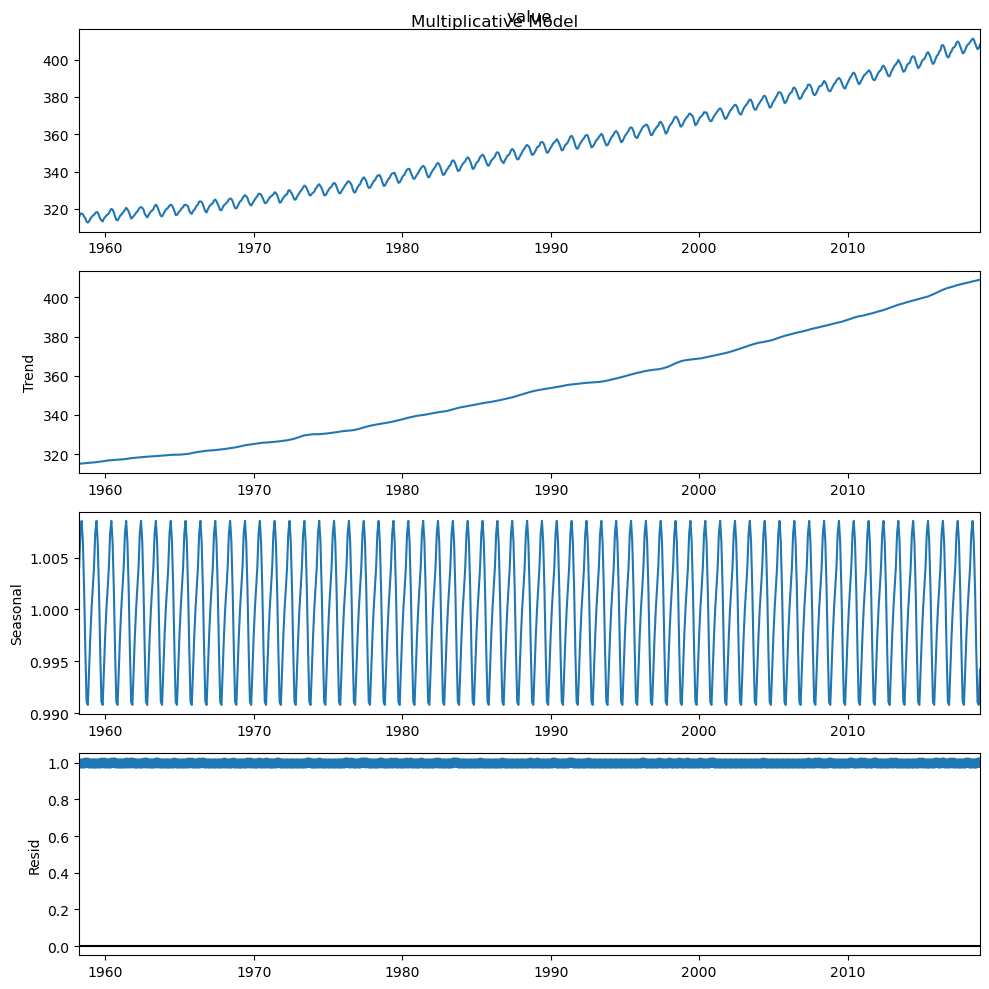

In [10]:
# Декомпозиція
df_cardox.index = pd.date_range(start=df_cardox.index[0], periods=len(df_cardox), freq='M')
result_M = seasonal_decompose(df_cardox['value'], model='multiplicative', extrapolate_trend=12)

# Побудова графіку
plt.rcParams.update({'figure.figsize': (10, 10)})
result_M.plot().suptitle('Multiplicative Model')
plt.show()

In [11]:
result = sm.tsa.stattools.adfuller(df_cardox['value'], autolag='AIC')
print(f'ADF-statistics: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical values:')
    print(f'{key}, {value}')

ADF-statistics: 4.994847244403944
p-value: 1.0
Critical values:
1%, -3.439620010600208
Critical values:
5%, -2.8656309041017756
Critical values:
10%, -2.5689484851894413


In [12]:
# Діагностика отриманої моделі
def diagnose_model(df):
    X = df.index.values.reshape(-1, 1)
    y = df['value'].values

    model = LinearRegression()
    model.fit(X, y)

    # Виведення коефіцієнтів моделі
    print("Коефіцієнт наклона:", model.coef_[0])
    print("Перехоплення:", model.intercept_)

    # Визначення коефіцієнта детермінації R^2
    r_squared = model.score(X, y)
    print("Коефіцієнт детермінації R^2:", r_squared)

# Завантаження даних з файлу cardox.csv
df_cardox = pd.read_csv('cardox.csv')

# Виклик функції діагностики моделі
diagnose_model(df_cardox)

Коефіцієнт наклона: 0.12933619131868748
Перехоплення: 306.7088554409306
Коефіцієнт детермінації R^2: 0.9775633249008349


In [13]:
# Перетворення стовпця 'date' на тип datetime
df_cardox['date'] = pd.to_datetime(df_cardox['date'])

# Вибір числових функцій для виявлення аномалій
numerical_features = ['date', 'value']

# Отримання підмножини датасету з числовими функціями
X = df_cardox['date'].apply(lambda x: x.timestamp()).values.reshape(-1, 1)

# Навчання моделі гауссовського розподілу
gmm = GaussianMixture(n_components=2)  # Встановлення кількості компонентів, може змінюватися
gmm.fit(X)

# Оцінка ймовірностей для кожного прикладу
probabilities = gmm.score_samples(X)
threshold = np.percentile(probabilities, 5)  # Вибір порогового значення, може змінюватися

# Виявлення аномалій
anomalies = df_cardox[probabilities < threshold]
print("Кількість виявлених аномалій:", len(anomalies))
print(anomalies)

Кількість виявлених аномалій: 37
          date   value
0   1958-03-01  315.71
1   1958-04-01  317.45
2   1958-05-01  317.50
3   1958-06-01  317.10
4   1958-07-01  315.86
5   1958-08-01  314.93
6   1958-09-01  313.20
7   1958-10-01  312.66
8   1958-11-01  313.33
9   1958-12-01  314.67
10  1959-01-01  315.62
11  1959-02-01  316.38
12  1959-03-01  316.71
13  1959-04-01  317.72
14  1959-05-01  318.29
15  1959-06-01  318.15
16  1959-07-01  316.54
17  1959-08-01  314.80
710 2017-05-01  409.69
711 2017-06-01  408.88
712 2017-07-01  407.12
713 2017-08-01  405.13
714 2017-09-01  403.37
715 2017-10-01  403.63
716 2017-11-01  405.12
717 2017-12-01  406.81
718 2018-01-01  407.96
719 2018-02-01  408.32
720 2018-03-01  409.41
721 2018-04-01  410.24
722 2018-05-01  411.24
723 2018-06-01  410.79
724 2018-07-01  408.71
725 2018-08-01  406.99
726 2018-09-01  405.51
727 2018-10-01  406.00
728 2018-11-01  408.02


In [14]:
# Обчислення середнього значення обсягів продажів
mean_value = df_cardox['value'].mean()

# Створення копії датасету з оригінальними даними
df_cardox_corrected = df_cardox.copy()

# Заміна аномальних значень на середнє значення
df_cardox_corrected.loc[probabilities < threshold, 'value'] = mean_value

# Виведення скоригованого датасету
df_cardox_corrected

,date,value
0,1958-03-01,353.787229
1,1958-04-01,353.787229
2,1958-05-01,353.787229
3,1958-06-01,353.787229
4,1958-07-01,353.787229
...,...,...
724,2018-07-01,353.787229
725,2018-08-01,353.787229
726,2018-09-01,353.787229
727,2018-10-01,353.787229


In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Перетворення індексу на тип DateTimeIndex
df_cardox['date'] = pd.to_datetime(df_cardox['date'])
df_cardox.set_index('date', inplace=True)

# Проведення декомпозиції часового ряду
result = seasonal_decompose(df_cardox['value'], model='additive')

# Отримання скоригованого ряду
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Заповнення пропущених значень
df_cardox['value'] = df_cardox['value'].fillna(trend + seasonal)

# Вивід результатів
print("Trend:")
print(trend)
print("\nSeasonal:")
print(seasonal)
print("\nResidual:")
print(residual)

Trend:
date
1958-03-01   NaN
1958-04-01   NaN
1958-05-01   NaN
1958-06-01   NaN
1958-07-01   NaN
              ..
2018-07-01   NaN
2018-08-01   NaN
2018-09-01   NaN
2018-10-01   NaN
2018-11-01   NaN
Name: trend, Length: 729, dtype: float64

Seasonal:
date
1958-03-01    1.447607
1958-04-01    2.583517
1958-05-01    3.021940
1958-06-01    2.311611
1958-07-01    0.695736
                ...   
2018-07-01    0.695736
2018-08-01   -1.472033
2018-09-01   -3.151205
2018-10-01   -3.248046
2018-11-01   -2.058747
Name: seasonal, Length: 729, dtype: float64

Residual:
date
1958-03-01   NaN
1958-04-01   NaN
1958-05-01   NaN
1958-06-01   NaN
1958-07-01   NaN
              ..
2018-07-01   NaN
2018-08-01   NaN
2018-09-01   NaN
2018-10-01   NaN
2018-11-01   NaN
Name: resid, Length: 729, dtype: float64


In [16]:
df_cardox.columns

Index(['value'], dtype='object')

In [17]:
# Використаємо лінійну регресію і оцінимо її за допомогою MSE, MAE та R-квадрат.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#скидаємо індекс для повернення стовпця date в датасет
df_cardox = df_cardox.reset_index()

# Підготовка матриці ознак X та вектора цільових значень y
X = df_cardox[['date']]  
y = df_cardox['value']   

# Розділення даних на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Перетворення дат на числові значення
X_train_numeric = X_train['date'].apply(lambda x: x.timestamp()).values.reshape(-1, 1)
X_test_numeric = X_test['date'].apply(lambda x: x.timestamp()).values.reshape(-1, 1)

# Ініціалізація та навчання моделі лінійної регресії
model = LinearRegression()
model.fit(X_train_numeric, y_train)

# Передбачення значень для тестового набору
y_pred = model.predict(X_test_numeric)

# Оцінка метрик моделі
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Виведення метрик
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R^2 Score:', r2)

Mean Squared Error (MSE): 15.927430783702214
Mean Absolute Error (MAE): 3.2078493399170607
R^2 Score: 0.9770607058135679


In [18]:
from sklearn.model_selection import cross_val_score

# Крос-валідація з використанням 5-ти блоків
scores = cross_val_score(model, X_train_numeric, y_train, cv=5, scoring='r2')

# Виведення кожного значення R^2
print('R^2 на кожному блоку:', scores)

# Виведення середнього значення R^2
print('Середнє значення R^2:', scores.mean())

R^2 на кожному блоку: [0.98159978 0.97584816 0.97948515 0.97587159 0.97106283]
Середнє значення R^2: 0.9767735026902995


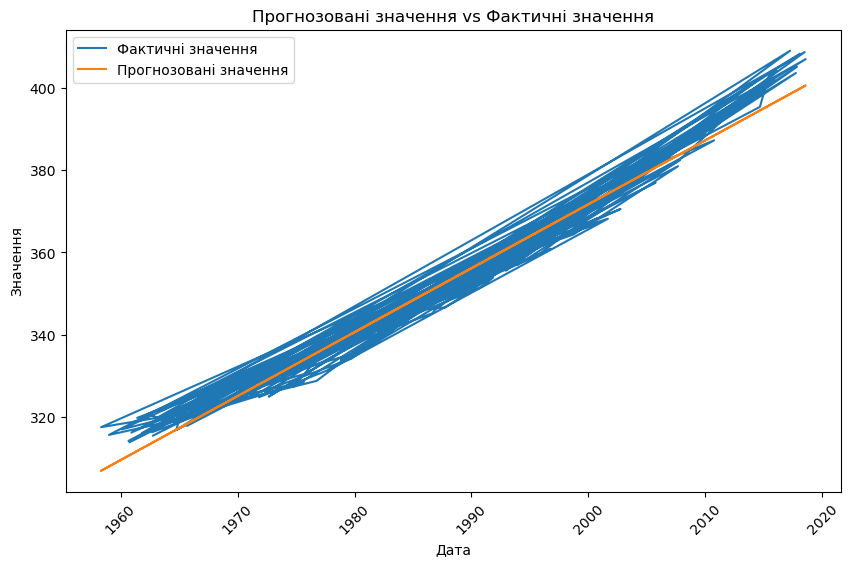

In [19]:
import matplotlib.pyplot as plt

# Побудова графіка прогнозованих значень та фактичних значень
plt.figure(figsize=(10, 6))
plt.plot(X_test['date'], y_test, label='Фактичні значення')
plt.plot(X_test['date'], y_pred, label='Прогнозовані значення')
plt.xlabel('Дата')
plt.ylabel('Значення')
plt.title('Прогнозовані значення vs Фактичні значення')
plt.legend()
plt.xticks(rotation=45)
plt.show()

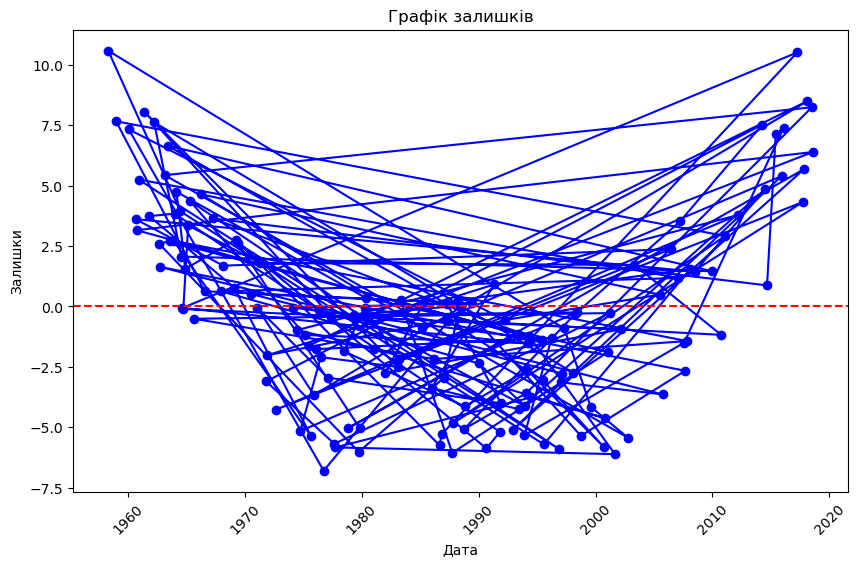

Середнє значення залишків: -0.16942432972298313
Стандартне відхилення залишків: 4.001046434078188


In [20]:
# Обчислення залишків
residuals = y_test - y_pred

# Побудова графіка залишків
plt.figure(figsize=(10, 6))
plt.plot(X_test['date'], residuals, marker='o', linestyle='-', color='b')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Залишки')
plt.title('Графік залишків')
plt.xticks(rotation=45)
plt.show()

# Обчислення середнього значення залишків
mean_residuals = residuals.mean()

# Обчислення стандартного відхилення залишків
std_residuals = residuals.std()

# Виведення статистичних показників залишків
print('Середнє значення залишків:', mean_residuals)
print('Стандартне відхилення залишків:', std_residuals)

In [21]:
# Виконання прогнозу на 30 років
def forecast(df, years):
    X = df.index.values.astype(int).reshape(-1, 1)
    y = df['value'].values

    model = LinearRegression()
    model.fit(X, y)

    # Генерація дат для прогнозу
    last_date = df.index[-1]
    forecast_dates = pd.date_range(last_date, periods=years * 12, freq='M')

    # Прогнозування значень
    forecast_values = model.predict(forecast_dates.values.astype(int).reshape(-1, 1))

    # Створення датафрейму з прогнозованими значеннями
    forecast_df = pd.DataFrame({'date': forecast_dates, 'value': forecast_values})
    forecast_df = forecast_df.set_index('date')

    return forecast_df

# Виклик функції прогнозу на 30 років
forecast_df = forecast(df_cardox, years=30)

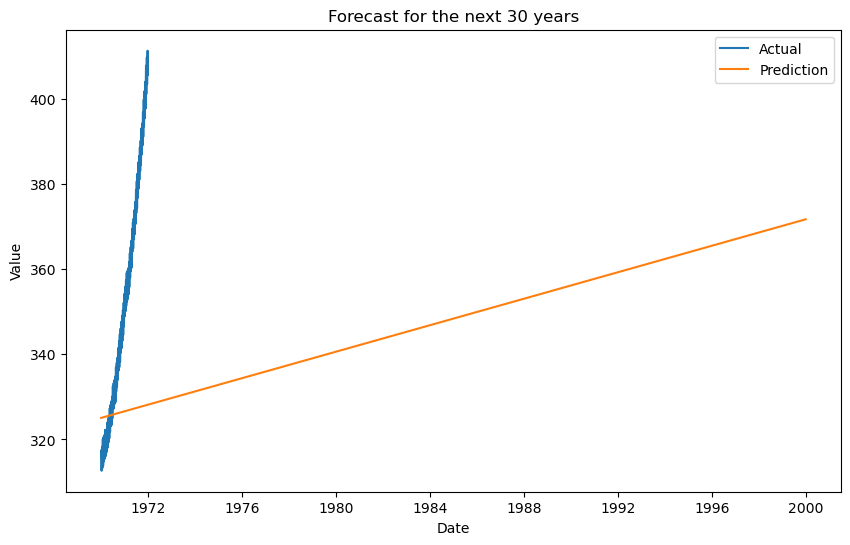

In [22]:
# Створення діапазону дат на 30 років у майбутньому
future_dates = pd.date_range(start=df_cardox.index[-1], periods=30*365, freq='D')

# Перетворення дат на числові значення
future_dates_numeric = future_dates.to_series().apply(lambda x: x.timestamp()).values.reshape(-1, 1)

# Виконання прогнозу на майбутні дати
future_predictions = model.predict(future_dates_numeric)

# Створення нового датафрейму для майбутніх прогнозів
df_future_predictions = pd.DataFrame({'date': future_dates, 'prediction': future_predictions})

# Візуалізація майбутніх прогнозів
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot_date(df_cardox.index, df_cardox['value'], '-', label='Actual')
plt.plot_date(df_future_predictions['date'], df_future_predictions['prediction'], '-', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast for the next 30 years')
plt.legend()
plt.show()

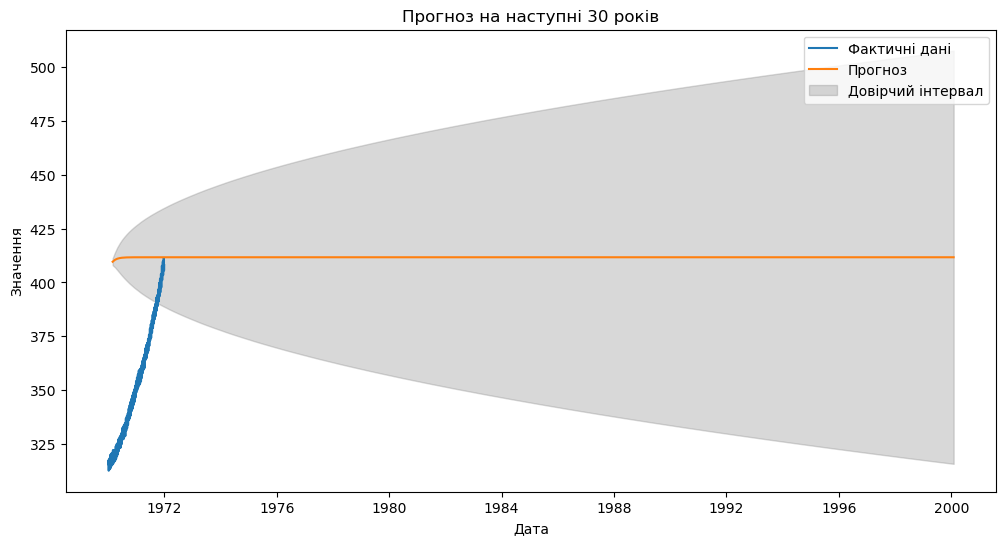

In [29]:
# Побудова моделі ARIMA
model = ARIMA(df_cardox['value'], order=(1, 1, 1))
model_fit = model.fit()

# Прогноз на 30 років
forecast_steps = 30 * 12  # 30 років * 12 місяців
forecast = model_fit.get_forecast(steps=forecast_steps)

# Отримання прогнозованих значень та довірчого інтервалу
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Створення дат для прогнозованих значень
forecast_dates = pd.date_range(start=df_cardox.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Візуалізація прогнозу та довірчого інтервалу
plt.figure(figsize=(12, 6))
plt.plot(df_cardox.index, df_cardox['value'], label='Фактичні дані')
plt.plot(forecast_dates, forecast_values, label='Прогноз')
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='Довірчий інтервал')
plt.xlabel('Дата')
plt.ylabel('Значення')
plt.title('Прогноз на наступні 30 років')
plt.legend()
plt.show()

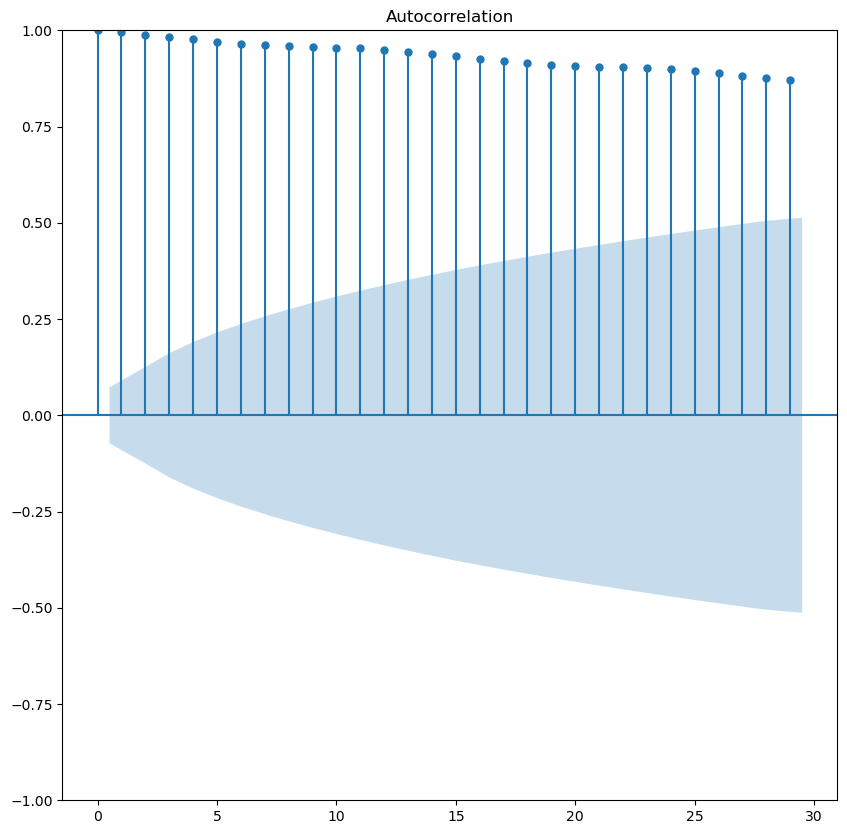

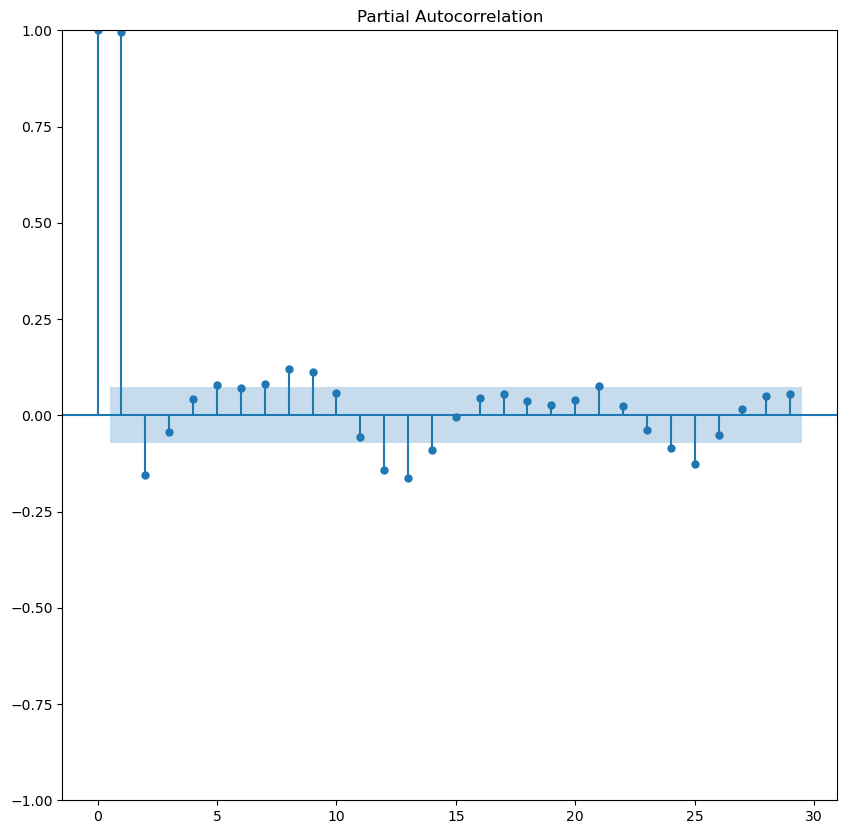

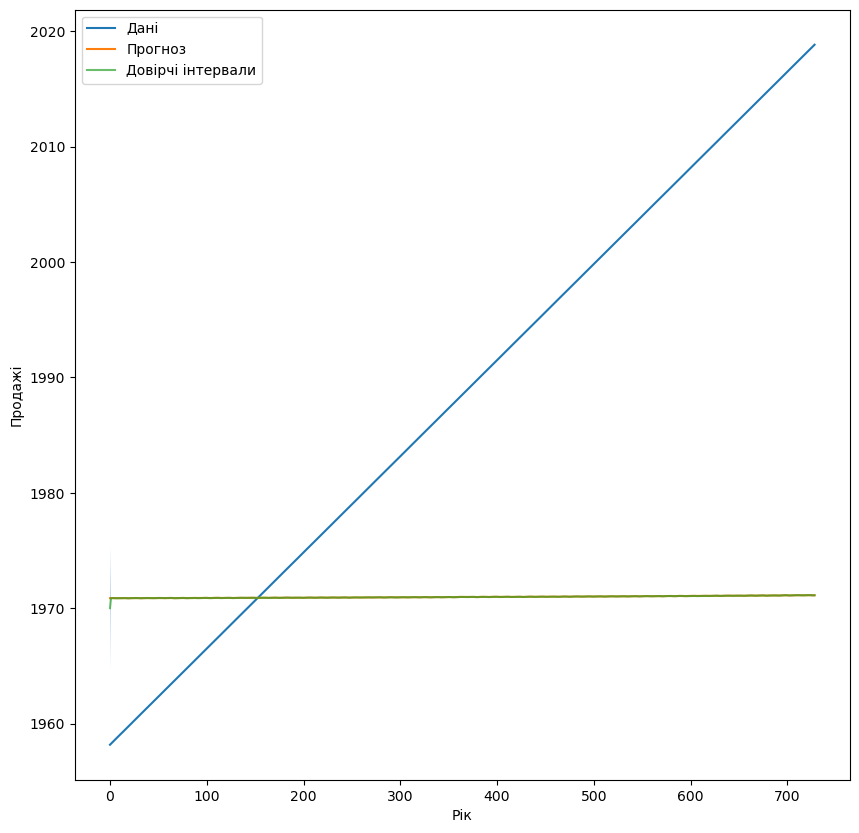

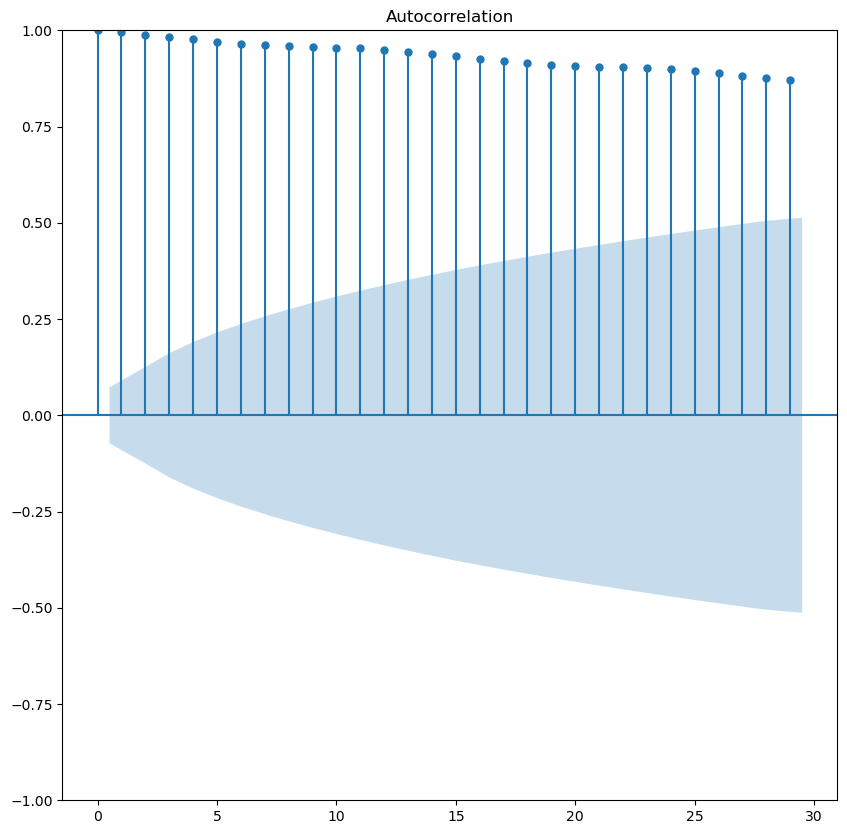

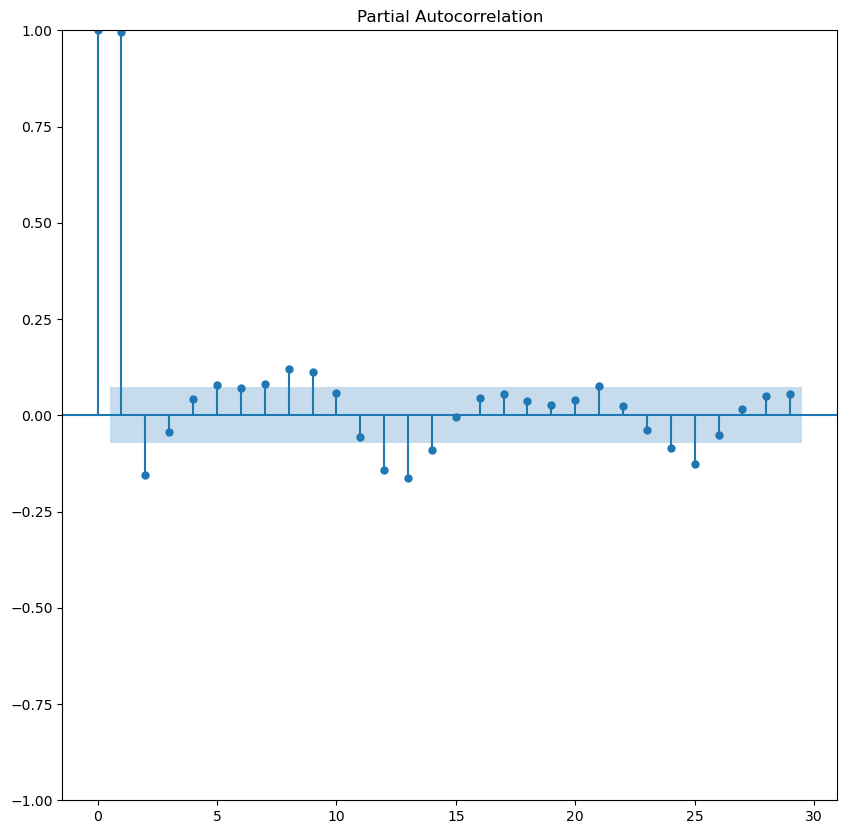

In [30]:
# Застосовуємо модель та отримуємо результати

# Виведення графіків ACF та PACF
plot_acf(df_cardox['value'])
plot_pacf(df_cardox['value'])

# Вибір оптимальних значень p, d, q з графіків
p = 1  # Порядок авторегресії
d = 1  # Різниця
q = 1  # Порядок ковзного середнього

model = ARIMA(df_cardox['value'], order=(p, d, q))
results = model.fit()

# Визначаємо початкову дату для прогнозу
start_index = df_cardox.index[0]

# Отримуємо прогнозовані значення та довірчі інтервали
pred = results.get_prediction(start=start_index, dynamic=False)
pred_ci = pred.conf_int()

# Побудова графіку з даними, прогнозом та довірчими інтервалами
ax = df_cardox.plot()
pred.predicted_mean.plot(ax=ax, alpha=.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], alpha=.3)

# Додавання підписів та легенди
plt.legend(('Дані', 'Прогноз', 'Довірчі інтервали'))
ax.set_xlabel('Рік')
ax.set_ylabel('Продажі')

# Виведення графіків ACF та PACF
plot_acf(df_cardox['value'])
plot_pacf(df_cardox['value'])

# Відображення графіку
plt.show()

In [31]:
# Збереження результатів прогнозування у файл
df_future_predictions.to_csv('predictions.csv', index=False)